## 1. Data preprocessing

In [1]:
import os
import pandas as pd
import random
from sklearn import preprocessing
import matplotlib.pyplot as plt
import category_encoders
from sklearn.decomposition import PCA

### 1.1 Import and merge the data

In [2]:
#os.chdir("/kaggle/input/ieee-fraud-detection")
#os.listdir()

In [3]:
# import the data
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')

# merge identity and transaction to one dataframe
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
# train_raw, test_raw = train.copy(), test.copy()

del train_identity, train_transaction, test_identity, test_transaction

The computation on the whole data set is too expensive, so I randomly select a subset of size 5000 for demo. Note that you should not run the code in following cell if you want to train a precise model.

In [4]:
sampleIdx = random.sample([i for i in range(train.shape[0])], k=5000)
train = train.iloc[sampleIdx, :]
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
234486,3221486,0,5539635,261.95,W,7585,553.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
510134,3497134,0,13364495,141.00,W,16132,111.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561462,3548462,0,14863128,300.00,R,14182,562.0,150.0,mastercard,102.0,...,ie 11.0 for desktop,24.0,1680x1050,match_status:2,T,F,T,T,desktop,Trident/7.0
66966,3053966,0,1527287,226.00,W,10023,111.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359681,3346681,0,8904242,146.00,W,10989,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(f'Training dataset has {train.shape[0]} observations and {train.shape[1]} features.')
print(f'Test dataset has {test.shape[0]} observations and {test.shape[1]} features.')

Training dataset has 5000 observations and 434 features.
Test dataset has 506691 observations and 433 features.


In [6]:
Ytr = train["isFraud"]
X = train.drop(["isFraud","TransactionID", "TransactionDT"], axis=1).append(test.drop(["TransactionID", "TransactionDT"], axis=1))
# X_raw, Ytr_raw = X.copy(), Ytr.copy()

### 1.2 Handle missing values

At first, I dropt features with high proporation (70%) of missing values. Then, I filled missing values in categorical variables with their mode, and filled missing values in numerical variables with their mean.

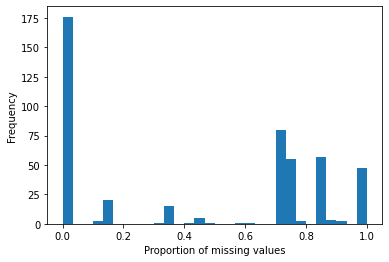

In [7]:
# proporation of missing values
missPropor = [X[col].isnull().sum() / X.shape[0] for col in X.columns]
plt.hist(missPropor, bins=30)
plt.ylabel("Frequency")
plt.xlabel("Proportion of missing values")
plt.show()

In [8]:
# delete features with high proporation of missing values
many_null_cols = [X.columns[i] for i in range(X.shape[1]) if missPropor[i] > 0.7]
X = X.drop(many_null_cols, axis=1)
print(f"After deleting features with high proporation of missing values, there are {X.shape[1]} features.")

After deleting features with high proporation of missing values, there are 223 features.


In [9]:
# fill missing values in categorical variables with their mode.
# fill missing values in numerical variables with their mean.
for i in range(X.shape[1]):
    if missPropor[i] > 0:
        if X.iloc[:, i].dtype == "object":
            X.iloc[:, i] = X.iloc[:, i].fillna(X.iloc[:, i].mode()[0])
        elif X.iloc[:, i].dtype in ['int64', 'float64']:
            X.iloc[:, i] = X.iloc[:, i].fillna(X.iloc[:, i].mean())

### 1.3 Encode categorical variables

In the following part, I tried two different ways: numeric encoding and binary encoding. [Here](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931) is the reason why I did that.

Numeric encoding (label encoding) simply assigns a value to each category. Binary encoding hashes the cardinalities into binary values.

In [10]:
# numeric encoding (label encoding)
X_le = X.copy()
for f in X.columns:
    if X_le[f].dtype == 'object': 
        le = preprocessing.LabelEncoder()
        le.fit(list(X_le[f].values))
        X_le[f] = le.transform(list(X_le[f].values))

In [11]:
# binary encoding
X_be = X.copy()
for f in X.columns:
    if X_be[f].dtype == 'object': 
        if X_be[f].nunique() <= 2:
            le = preprocessing.LabelEncoder()
            le.fit(list(X_be[f].values))
            X_be[f] = le.transform(list(X_be[f].values))
        else:
            be = category_encoders.BinaryEncoder(cols=f)
            X_be = be.fit_transform(X_be)

### 1.4 PCA to reduce dimension

Although PCA can reduce dimension and computation time, the result showed that the prediction performance with PCA is worse. So I will not use the data after PCA to fit the model and make predictions in the modeling part.

In [12]:
X_le_pca = X_le.copy()

In [13]:
# standardize the data
scaler = preprocessing.StandardScaler()
scaler.fit(X_le_pca)
X_le_pca = scaler.transform(X_le_pca)

In [14]:
# apply PCA
# choose the minimum number of principal components 
# such that 99% of the variance is retained.
pca = PCA(0.99)
pca.fit(X_le_pca)
X_le_pca = pca.transform(X_le_pca)
X_le_pca = pd.DataFrame(X_le_pca)

In [15]:
print(f"Number of features after PCA is {X_le_pca.shape[1]}.")

Number of features after PCA is 139.


### 1.5 Save processed data

In [16]:
Xtr_le = X_le.iloc[:train.shape[0], :]
Xte_le = X_le.iloc[train.shape[0]:, :]
Xtr_be = X_be.iloc[:train.shape[0], :]
Xte_be = X_be.iloc[train.shape[0]:, :]
Xtr_le_pca = X_le_pca.iloc[:train.shape[0], :]
Xte_le_pca = X_le_pca.iloc[train.shape[0]:, :]

In [40]:
Xtr_be.head()

,TransactionAmt,ProductCD_0,ProductCD_1,ProductCD_2,card1,card2,card3,card4_0,card4_1,card4_2,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
234486,261.95,0,0,1,7585,553.0,150.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
510134,141.00,0,0,1,16132,111.0,150.0,0,0,1,...,0.0,0.0,206.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
561462,300.00,0,1,0,14182,562.0,150.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66966,226.00,0,0,1,10023,111.0,150.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359681,146.00,0,0,1,10989,360.0,150.0,0,0,1,...,0.0,160.5,160.5,160.5,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Xtr_le.to_csv(f"{path}X_train_labelencoding.csv", index=False)
# Xte_le.to_csv(f"{path}X_test_labelencoding.csv", index=False)
# Xtr_be.to_csv(f"{path}X_train_binaryencoding.csv", index=False)
# Xte_be.to_csv(f"{path}X_test_binaryencoding.csv", index=False)
# Xtr_le_pca.to_csv(f"{path}X_train_labelencoding_pca.csv", index=False)
# Xte_le_pca.to_csv(f"{path}X_test_labelencoding_pca.csv", index=False)
# Ytr.to_csv(f"{path}Y_train.csv", header="isFraud", index=False)

## 2. Modeling

In [19]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [20]:
# path = '/home/wkm/Documents/Data set/ieee-fraud-detection/'
# Xtr = pd.read_csv(f"{path}X_train_binaryencoding.csv")
# Xte = pd.read_csv(f"{path}X_test_binaryencoding.csv")
# Ytr = pd.read_csv(f"{path}Y_train.csv")

In [21]:
Xtr = Xtr_be
Xte = Xte_be

In [22]:
test_transaction = pd.read_csv('test_transaction.csv')
submission = pd.DataFrame(test_transaction["TransactionID"])
del test_transaction

### 2.1 Logistic regression

The prediction score is 0.713617.

In [23]:
lr = LogisticRegression(penalty='l2', max_iter=500, n_jobs=6, tol=1e-6, solver="sag")
lr.fit(Xtr, np.ravel(Ytr))
Yhat_lr = lr.predict_proba(Xte)
submission["isFraud"] = Yhat_lr[:, 1]
# submission.to_csv(f"{path}Y_hat_logistic.csv", index=False)

E:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### 2.2 Bagging trees

I use RandomForestClassifier and set max_features="auto", which means max_features=n_features, so it is bagging.

In [24]:
treeCount = 100

bagging = RandomForestClassifier(max_features="auto", min_samples_leaf=1, n_estimators=treeCount)
bagging.fit(Xtr, np.ravel(Ytr))
Yhat_bagging = bagging.predict_proba(Xte)
submission["isFraud"] = Yhat_bagging[:, 1]
# submission.to_csv(f"{path}Y_hat_bagging.csv", index=False)

### 2.3 Random forests

Let's first do parameter tunning.

In [25]:
# use oob error to find the best max_features
nFeatures = Xtr.shape[1]
oobErrList = list()
mList = [m for m in range(10, nFeatures+1, 30)]

for m in mList:
    rf = RandomForestClassifier(max_features=m, min_samples_leaf=1,\
                                oob_score=True, n_estimators=50)
    rf.fit(Xtr, np.ravel(Ytr))
    oobErrList.append(1-rf.oob_score_)
    print(m, 1-rf.oob_score_)

10 0.03280000000000005
40 0.03259999999999996
70 0.03380000000000005
100 0.031200000000000006
130 0.033399999999999985
160 0.03380000000000005
190 0.03400000000000003
220 0.03320000000000001


[0.03280000000000005, 0.03259999999999996, 0.03380000000000005, 0.031200000000000006, 0.033399999999999985, 0.03380000000000005, 0.03400000000000003, 0.03320000000000001]


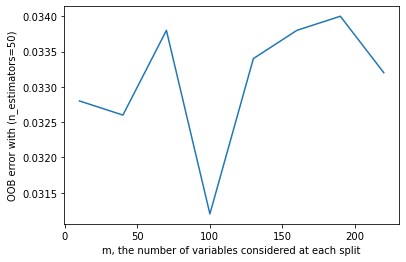

In [26]:
print(oobErrList)
plt.plot([m for m in range(10, nFeatures+1, 30)], oobErrList)
plt.ylabel('OOB error with (n_estimators=50)')
plt.xlabel('m, the number of variables considered at each split')
plt.show()

Other than max_features (the number of variables considered at each split), the parameter n_estimators (the number of trees) is also important. However, the prediction performance will increase with the increase of n_estimators, so we should select the highest n_estimators as long as our machine can compute it. 

I tried different parameters (max_features and n_estimators) and get the prediction scores (evaluted by AUC) as following.

|max_features | n_estimators | PCA | prediction score |
|---|---|---|---|
| 223 | 100 | 99%  | 0.871838 |
| 190 | 100 | 100% | 0.892415 |
| 100 | 100 | 100% | 0.894553 |
| 50  | 100 | 100% | 0.895868 |
| 223 | 100 | 100% | 0.896448 |
| 90  | 200 | 100% | 0.898140 |
| 100 | 200 | 100% | 0.899070 |
| 50  | 200 | 100% | 0.900798 |
| 15  | 1000| 100% | 0.904874 |

From the table above, we can see that max_features does not infulence the prediction performance significantly, but n_estimators does.

In [27]:
treeCount = 1000
m = 15

rf = RandomForestClassifier(max_features=m, min_samples_leaf=1, n_estimators=treeCount)
rf.fit(Xtr, np.ravel(Ytr))
Yhat_rf = rf.predict_proba(Xte)

In [28]:
submission["isFraud"] = Yhat_rf[:, 1]
# submission.to_csv(f"{path}Y_hat_rf_m{m}_t{treeCount}.csv", index=False)

### 2.4 Gradient boosting

At first, let's try gradient boosting with default parameters. The prediction scroe on test data set is 0.891210.

In [30]:
# use default parameters
gbm0 = GradientBoostingClassifier()
gbm0.fit(Xtr, np.ravel(Ytr))
submission["isFraud"] = gbm0.predict_proba(Xte)[:, 1]
#submission.to_csv(f"Y_hat_gbm_default.csv", index=False)

Now let's do parameter tunning. The parameters n_estimators and learning_rate are corrlated, so we need to tune them together. Let's use grid search to find the best number of weak learners (n_estima****tors) and the best step size (learning_rate). 

In [31]:
param_test1 = {'n_estimators':range(100, 1200, 100), 'learning_rate':[0.01, 0.1, 1]}
gbm_tune1 = GradientBoostingClassifier(max_features='sqrt', min_samples_leaf=0.001, max_depth=4)

gs1 = GridSearchCV(estimator=gbm_tune1, param_grid=param_test1, scoring='roc_auc', n_jobs=6, cv=5)
gs1.fit(Xtr, np.ravel(Ytr))

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4,
                                                  max_features='sqrt',
                                                  min_samples_leaf=0.001),
             n_jobs=6,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': range(100, 1200, 100)},
             scoring='roc_auc')

In [32]:
print(f"The best parameters: {gs1.best_params_}, and the highest mean_test_score is {gs1.best_score_}")

The best parameters: {'learning_rate': 0.01, 'n_estimators': 600}, and the highest mean_test_score is 0.8217114310572254


However, I found that n_estimators=600 is unaffordable for computation, so I still set it to 100. Now let's tune the tree parameters max_depth and min_samples_leaf.

In [33]:
param_test2 = {'max_depth':range(2, 16, 2), 'min_samples_leaf':[10**i for i in range(-5,0)]}
gbm_tune2 = GradientBoostingClassifier(max_features='sqrt', n_estimators=100, learning_rate=0.1)

gs2 = GridSearchCV(estimator=gbm_tune2, param_grid=param_test2, scoring='roc_auc', n_jobs=6, cv=5)
gs2.fit(Xtr, np.ravel(Ytr))

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(max_features='sqrt'),
             n_jobs=6,
             param_grid={'max_depth': range(2, 16, 2),
                         'min_samples_leaf': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
             scoring='roc_auc')

In [34]:
print(f"The best parameters: {gs2.best_params_}, and the highest mean_test_score is {gs2.best_score_}")

The best parameters: {'max_depth': 8, 'min_samples_leaf': 0.001}, and the highest mean_test_score is 0.8181078274536219


In [36]:
# use tuned parameters
gbm1 = GradientBoostingClassifier(max_depth=10, min_samples_leaf=0.001, 
                                  learning_rate=0.1, n_estimators=100)
gbm1.fit(Xtr, np.ravel(Ytr))
submission["isFraud"] = gbm1.predict_proba(Xte)[:, 1]
#submission.to_csv(f"Y_hat_gbm_tuned1.csv", index=False)

After parameters tuning, the prediction score (by AUC) on test data set is 0.919523. It is beeter than that without parameters tuning.

### 2.5 XGBoost

The prediction scroe on test data set by XGBoost with default parameters is 0.900976, and 0.931355 with the parameters tuned by GBT (see section 2.4 Gradient boosting).

In [37]:
xgbc = xgb.XGBClassifier(n_jobs=4, max_depth=10, min_samples_leaf=0.001, 
                         learning_rate=0.1, n_estimators=100, eval_metric="auc")
xgbc.fit(Xtr, np.ravel(Ytr))
submission["isFraud"] = xgbc.predict_proba(Xte)[:, 1]

E:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:33:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [38]:
#submission.to_csv(f"Y_hat_xgb_tuned5.csv", index=False)